Text Classification with a Bag-of-Words model
==============================================

This notebook demonstrates how we can train a classifier to predict a label for a text based on word counts.

The texts consist of 19th century novels in English from project Gutenberg. The selection is based on the "unsuccessful" and successful novels (low and high download counts) as used in Ashok et al (2013), [Success with style](http://aclweb.org/anthology/D13-1181).

We will consider the same classification task of successful vs unsuccessful novels.

First some preliminaries. Import the external libraries we will use.
Most importantly, we rely on Scikit-Learn to do machine learning. See http://scikit-learn.org/

In [258]:
import os
import numpy
import pandas
import matplotlib.pyplot as plt
import sklearn.feature_extraction
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.decomposition
import sklearn.linear_model
import sklearn.metrics
import seaborn as sns

# Tweak how tables are displayed
pandas.set_option('display.precision', 4)
pandas.set_option('display.max_colwidth', 30)
pandas.set_option('display.colheader_justify', 'left')

Load the texts and convert to a bag-of-words table
--------------------------------------------------
The bag-of-words ([BOW](http://en.wikipedia.org/wiki/Bag-of-words_model)) table will contain a count for each text and every word.

All letters are converted to lower case and we filter the words until we only have words with two or more alphanumeric characters (no punctuation).

Important parameters are:

-  ``max_features`` limits the model to consider only the top *n* most frequent words. More is often better but may be slow to compute.
- ``min_df`` and ``max_df`` restrict the words to those that occur in a certain proportion of texts.

For example, setting these to the values 0.2 and 0.8, respectively, restricts the model to words that are in at least 20%, and at most 80% of the texts. This removes rare words on the one hand, and ignores highly frequent words such as [function words](http://en.wikipedia.org/wiki/Function_word) on the other.

- ``use_idf=True`` turns on [tf-idf](http://en.wikipedia.org/wiki/Tf%E2%80%93idf) weighting; this incorporates not only the total frequency of a word, but also the number of texts in which it appears. This means that words which are frequent in one text but not in others will get a high score, while words that are frequent in all documents receive a lower score.
- ``sublinear_tf=True`` is another variation which makes the word frequencies logarithmic.
- ``ngram_range``: selects the number of words in each feature; the default of ``(1, 1)`` selects individual words, which is most efficient. Higher numbers result in more informative features, but also requires a lot more memory. Bigrams, i.e., ``ngram_range=(2, 2)`` is a good trade-off and yields features with 2 consecutive words such as ``the man`` and ``man walks`` etc.

In [259]:
# Set up a simple BOW model
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(
        input='filename', lowercase=True, token_pattern=r'\b[-\w]{2,}\b',
        min_df=0.2, max_df=0.8, max_features=10000,
        use_idf=True, sublinear_tf=False, ngram_range=(1, 3))

# Get a list of all filenames in the 'train/' folder,
# and add their text to the BOW table 'X'.
filenames = os.listdir('train/')
X = vectorizer.fit_transform(['train/' + a for a in filenames])

Inspect the vector representation
---------------------------------
To see what the vector representation looks like, we will look at how a simple [example](https://en.wikipedia.org/wiki/It_was_a_dark_and_stormy_night) is transformed to the BOW representation.

Notice that because of the parameters before, many words are ignored.

In [260]:
text = ('It was a dark and stormy night; '
        'the rain fell in torrents -- except at occasional intervals, '
        'when it was checked by a violent gust of wind which swept '
        'up the streets (for it is in London that our scene lies), '
        'rattling along the housetops, and fiercely agitating the scanty '
        'flame of the lamps that struggled against the darkness.')
with open('darkandstormy.txt', 'w', encoding='utf8') as out:
    out.write(text)
vec = vectorizer.transform(['darkandstormy.txt'])    

# we get back a large vector with a value for each possible word.
# show a table with only the non-zero items in the vector:
feature_names = vectorizer.get_feature_names()
pandas.DataFrame([(feature_names[b], (a, b), vec[a, b])
                        for a, b in zip(*vec.nonzero())],
                       columns=['word', 'index', 'weight'])

,word,index,weight
0,wind,"(0, 9634)",0.1560
1,when it was,"(0, 9482)",0.2073
2,when it,"(0, 9481)",0.1547
3,violent,"(0, 9097)",0.2019
4,the streets,"(0, 8139)",0.2057
5,the rain,"(0, 8052)",0.2263
6,the darkness,"(0, 7731)",0.1773
7,that our,"(0, 7581)",0.2069
8,swept,"(0, 7400)",0.1779
9,struggled,"(0, 7303)",0.2045


Get label for each text
----------------------
The genre of each text, whether a text is a "success" or a "failure" (based on download counts), and some other information, is specified in a separate metadata file.

Note that in the original data, a text may have multiple genres, and an arbitrary genre was picked in this case. In a more careful study the single most appropriate genre would have to be selected by hand.

In [261]:
# Print the first 5 lines to see what the metadata looks like:
for line in list(open('metadata.csv', encoding='utf8'))[:5]:
    print(line, end='')

Filename,Label,Genre,Fold,Success,Title,Author,Language,DownloadCount
103.txt,Verne_AroundTheWorldIn80Days,Adventure,1,SUCCESS,around the world in 80 days,"verne, jules, 1828-1905",en,3260
1145.txt,Hope_RupertOfHentzau,Adventure,1,SUCCESS,rupert of hentzau,"hope, anthony, 1863-1933",en,141
1947.txt,Sabatini_Scaramouche,Adventure,1,SUCCESS,scaramouche,"sabatini, rafael, 1875-1950",en,434
18857.txt,Verne_AJourneyToTheCenterOfThe,Adventure,1,SUCCESS,a journey to the center of the earth,"verne, jules, 1828-1905",en,336


In [262]:
# Load the data; metadata.index will be the filename.
metadata = pandas.read_csv('metadata.csv', index_col='Filename', encoding='utf8')
labels = dict(zip(metadata.index, metadata['Success']))

# collect the labels we want to predict
y = numpy.array([labels[a] for a in filenames])

# Create an abbreviated label "Author_Title" for each text
authors = dict(zip(metadata.index, metadata['Author']))
titles = dict(zip(metadata.index, metadata['Title']))
abbrtitles = ['%s_%s' % (authors[a].split(',')[0].title(),
        titles[a][:15].title()) for a in filenames]

Train a classifier
------------------

You can try different values for the parameter ``C``.
This parameter controls the level of regularization;
with higher values, the model will take more edge cases
(datapoints close to datapoints of other classes) into account.
This will give better scores on data that is similar to the training data,
but if the training data is not representative, it may result in more errors.



In [263]:
# Use the "Fold" column to split the training data into a train and test set.
# These folds were chosen in such a way that the labels are well balanced
# and all works by each other only occur in a single fold.
folds = dict(zip(metadata.index, metadata['Fold']))
sss = sklearn.model_selection.PredefinedSplit([folds[a] for a in filenames])
# Train a linear classifier and predict the genre of the items in the test set.
clf = sklearn.linear_model.LogisticRegression(C=1, multi_class='multinomial', solver='lbfgs')
for train_index, test_index in sss.split(X, y):
    clf.fit(X[train_index], y[train_index])
    pred = clf.predict(X[test_index])
    prob = clf.predict_proba(X[test_index])
print('Overall accuracy: %g %%' % sklearn.metrics.accuracy_score(y[test_index], pred))

Overall accuracy: 0.701987 %


In [238]:
clf.classes_

array(['FAILURE', 'SUCCESS'], dtype='<U7')

Evaluate the classifier
-----------------------
The breakdown shows that not all genres are predicted as well;
the f-score column is the most important.

In the [confusion matrix](http://en.wikipedia.org/wiki/Confusion_matrix)
we can see which genres were mistaken most often.
The columns hold the number of times the model predicted a genre,
while the rows show the true genres. The diagonal from the top-left to the bottom-right shows the number of correct classifications.

In [239]:
print(sklearn.metrics.classification_report(y[test_index], pred))
pandas.DataFrame(sklearn.metrics.confusion_matrix(y[test_index], pred),
                 index=clf.classes_, columns=clf.classes_)

              precision    recall  f1-score   support

     FAILURE       0.69      0.74      0.71        76
     SUCCESS       0.71      0.67      0.69        75

    accuracy                           0.70       151
   macro avg       0.70      0.70      0.70       151
weighted avg       0.70      0.70      0.70       151



,FAILURE,SUCCESS
FAILURE,56,20
SUCCESS,25,50


Which words are most strongly associated with each genre?
---------------------------------------------------------
For each genre, the top 10 words most strongly linked to each genre are shown.

The words are ordered by the weight of the model for each genre combined with the average frequency of that word.

In [240]:
# Sort the weights of the classifier and take top 10 items
topfeatures = {}
avgfreq = numpy.squeeze(numpy.asarray(X.mean(axis=0)))
if len(clf.classes_) > 2:
    for n, target in enumerate(clf.classes_):
        top10 = numpy.argsort(clf.coef_[n] * avgfreq)[::-1][:10]
        topfeatures[target] = pandas.DataFrame({
                'word': [feature_names[m] for m in top10],
                'score': (clf.coef_[n] * avgfreq)[top10]},
                index=range(1, 11))
else:
    # in case of a binary classification, negative weights are for the first class,
    # positive weights for the second
    top10 = numpy.argsort(clf.coef_[0] * avgfreq)[:10]
    topfeatures[clf.classes_[0]] = pandas.DataFrame({
            'word': [feature_names[m] for m in top10],
            'score': (clf.coef_[0] * avgfreq)[top10]},
            index=range(1, 11))
    top10 = numpy.argsort(clf.coef_[0] * avgfreq)[::-1][:10]
    topfeatures[clf.classes_[1]] = pandas.DataFrame({
            'word': [feature_names[m] for m in top10],
            'score': (clf.coef_[0] * avgfreq)[top10]},
            index=range(1, 11))
pandas.concat(topfeatures, axis=1)

FAILURE            SUCCESS         
   word       score   word     score  
1        miss -0.0201      sir  0.0241
2        girl -0.0200     thou  0.0221
3   exclaimed -0.0105       mr  0.0193
4        boys -0.0095       de  0.0169
5         tom -0.0095  she had  0.0133
6    the girl -0.0082      mrs  0.0097
7   the young -0.0080     thee  0.0096
8          er -0.0079       re  0.0091
9      doctor -0.0078     wind  0.0082
10      sweet -0.0077   letter  0.0080

Can the model predict labels for new texts?
---------------------------------------------

If you're done experimenting with the model parameters, we can load new texts that the model has never seen before, and see what it predicts.

In [241]:
# Since we now evaluate on an external held-out set,
# we can use everything as training data
clf.fit(X, y)

# Transform the new files to the format of the existing BOW table
newfiles = os.listdir('test/')
X1 = vectorizer.transform(['test/' + a for a in newfiles])
y1 = numpy.array([labels[a] for a in newfiles])
pred = clf.predict(X1)
prob = clf.predict_proba(X1)

# Evaluate
print(sklearn.metrics.classification_report(y1, pred))
pandas.DataFrame(sklearn.metrics.confusion_matrix(y1, pred),
                       index=clf.classes_,
                       columns=clf.classes_)

              precision    recall  f1-score   support

     FAILURE       0.72      0.68      0.70        80
     SUCCESS       0.69      0.73      0.71        79

    accuracy                           0.70       159
   macro avg       0.71      0.70      0.70       159
weighted avg       0.71      0.70      0.70       159



,FAILURE,SUCCESS
FAILURE,54,26
SUCCESS,21,58


In [242]:
# One DataFrame with all the metadata and a column for the predicted label.
# The prediction is correct if the value in the Success column and the predicted column are equal.
metapred = metadata.loc[newfiles, :]
metapred['predicted'] = pandas.Series(pred, newfiles)
metapred['prob'] = pandas.Series(prob.max(axis=1), newfiles)
metapred

,Label,Genre,Fold,Success,Title,Author,Language,DownloadCount,predicted,prob
Filename,,,,,,,,,,
12187.txt,Freeman_TheMysteryOf31NewInn,Mystery,1,SUCCESS,the mystery of 31 new inn,"freeman, r. austin (richar...",en,211,SUCCESS,0.8018
24353.txt,Thayer_WiredLove,Love,1,SUCCESS,wired love,"thayer, ella cheever, 1849...",en,139,FAILURE,0.7491
22326.txt,Hawes_TheComfortOfLovers,Poetry,1,FAILURE,the comfort of lovers,"hawes, stephen, -1523",en,3,FAILURE,0.5474
18509.txt,Goff_NickBabaSLastDrinkAnd...,Short,1,FAILURE,nick baba's last drink and...,"goff, george paul",en,6,SUCCESS,0.5854
12971.txt,Bosher_TheManInLonelyLand,Love,1,FAILURE,the man in lonely land,"bosher, kate langley, 1865...",en,9,FAILURE,0.7198
...,...,...,...,...,...,...,...,...,...,...
23550.txt,Murfree_UnaOfTheHillCountr...,Short,1,FAILURE,una of the hill country 1911,"murfree, mary noailles, 18...",en,6,FAILURE,0.6040
1880.txt,Cooper_PathfinderOrTheInla...,Historical,1,SUCCESS,"pathfinder; or, the inland...","cooper, james fenimore, 17...",en,185,FAILURE,0.6219
1260.txt,Brontë_JaneEyre,Love,1,SUCCESS,jane eyre,"brontë, charlotte, 1816-1855",en,9375,SUCCESS,0.6670


Genre
Adventure     0.7143
Fiction       0.7143
Historical    0.6923
Love          0.9000
Mystery       0.7500
Poetry        0.8571
Sci-Fi        0.5000
Short         0.6800
dtype: float64


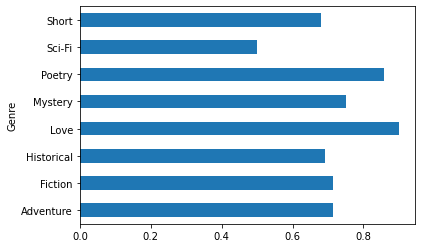

In [243]:
# Breakdown of accuracy scores by genre.
# NB: a book can have multiple genre labels, in this case it is reflected in the score of each genre label.
def getacc(df):
    return sklearn.metrics.accuracy_score(df['Success'], df['predicted'])

accbygenre = metapred.groupby('Genre').apply(getacc)
print(accbygenre)
accbygenre.plot.barh();

Which books were the hardest to classify?
-----------------------------------------

The following table lists the books ordered by how confident the classifier is; i.e., ordered by the probability for the most likely label. A probability ranges from 0 to 1; although in this case, the probabilities will range from 1/n to 1, where n is the number of possible labels. Therefore, with two labels, 0.5 means the model is maximally uncertain, while 1.0 would mean absolute certainty.

In [244]:
metapred.sort_values(by='prob')

,Label,Genre,Fold,Success,Title,Author,Language,DownloadCount,predicted,prob
Filename,,,,,,,,,,
18182.txt,Laut_HeraldsOfEmpireBeingT...,Historical,1,FAILURE,heralds of empire being th...,"laut, agnes c. (agnes chri...",en,16,SUCCESS,0.5004
12190.txt,Stockton_TheAdventuresOfCa...,Adventure,1,FAILURE,the adventures of captain ...,"stockton, frank richard, 1...",en,17,SUCCESS,0.5015
3180.txt,Twain_ADoubleBarrelledDete...,Mystery,1,SUCCESS,a double barrelled detecti...,"twain, mark, 1835-1910",en,311,SUCCESS,0.5023
23168.txt,Murray_ARideWithAMadHorseIn,Short,1,FAILURE,a ride with a mad horse in...,"murray, w. h. h. (william ...",en,6,FAILURE,0.5062
29458.txt,Sheckley_CostOfLiving,Sci-Fi,1,SUCCESS,cost of living,"sheckley, robert, 1928-2005",en,106,SUCCESS,0.5097
...,...,...,...,...,...,...,...,...,...,...
1290.txt,Flaubert_Salammbo,Fiction,2,SUCCESS,salammbo,"flaubert, gustave, 1821-1880",en,208,SUCCESS,0.8940
1290.txt,Flaubert_Salammbo,Love,1,SUCCESS,salammbo,"flaubert, gustave, 1821-1880",en,208,SUCCESS,0.8940
1290.txt,Flaubert_Salammbo,Historical,2,SUCCESS,salammbo,"flaubert, gustave, 1821-1880",en,305,SUCCESS,0.8940


In [245]:
y = metapred.sort_values(by='prob')

In [246]:
metapred.loc[metapred["Genre"] == "Historical"].sort_values(by='prob')

,Label,Genre,Fold,Success,Title,Author,Language,DownloadCount,predicted,prob
Filename,,,,,,,,,,
18182.txt,Laut_HeraldsOfEmpireBeingT...,Historical,1,FAILURE,heralds of empire being th...,"laut, agnes c. (agnes chri...",en,16,SUCCESS,0.5004
11228.txt,Chesnutt_TheMarrowOfTradition,Historical,1,SUCCESS,the marrow of tradition,"chesnutt, charles w. (char...",en,147,FAILURE,0.5345
7037.txt,Henty_BericTheBritonAStory...,Historical,1,SUCCESS,beric the briton : a story...,"henty, g. a. (george alfre...",en,188,SUCCESS,0.5591
7060.txt,Henty_AtAgincourt,Historical,1,SUCCESS,at agincourt,"henty, g. a. (george alfre...",en,116,SUCCESS,0.5748
14656.txt,Barr_TheSwordMaker,Historical,1,FAILURE,the sword maker,"barr, robert, 1850-1912",en,23,FAILURE,0.5993
14656.txt,Barr_TheSwordMaker,Historical,4,FAILURE,the sword maker,"barr, robert, 1850-1912",en,21,FAILURE,0.5993
1880.txt,Cooper_PathfinderOrTheInla...,Historical,1,SUCCESS,"pathfinder; or, the inland...","cooper, james fenimore, 17...",en,185,FAILURE,0.6219
1965.txt,Sabatini_CaptainBlood,Historical,3,SUCCESS,captain blood,"sabatini, rafael, 1875-1950",en,638,SUCCESS,0.6285
10094.txt,Stevenson_ASoldierOfVirgin...,Historical,1,FAILURE,a soldier of virginia a ta...,"stevenson, burton egbert, ...",en,11,FAILURE,0.6403


In [247]:
metapred.loc[metapred["Genre"] == "Sci-Fi"].sort_values(by='prob')

,Label,Genre,Fold,Success,Title,Author,Language,DownloadCount,predicted,prob
Filename,,,,,,,,,,
29458.txt,Sheckley_CostOfLiving,Sci-Fi,1,SUCCESS,cost of living,"sheckley, robert, 1928-2005",en,106,SUCCESS,0.5097
18109.txt,Piper_GraveyardOfDreams,Sci-Fi,1,SUCCESS,graveyard of dreams,"piper, h. beam, 1904-1964",en,115,FAILURE,0.5103
24927.txt,Sevcik_AMatterOfMagnitude,Sci-Fi,1,FAILURE,a matter of magnitude,"sevcik, al",en,29,SUCCESS,0.5186
30438.txt,Mckimmey_TheEyesHaveIt,Sci-Fi,1,FAILURE,the eyes have it,"mckimmey, james, 1923-",en,27,SUCCESS,0.5240
24517.txt,Baily_AccidentalDeath,Sci-Fi,1,SUCCESS,accidental death,"baily, peter",en,171,FAILURE,0.5243
30329.txt,Marlowe_BlackEyesAndTheDai...,Sci-Fi,1,FAILURE,black eyes and the daily g...,"marlowe, stephen, 1928-2008",en,23,FAILURE,0.5252
29601.txt,Robles_See,Sci-Fi,1,FAILURE,see?,"robles, edward g.",en,29,SUCCESS,0.5264
26955.txt,Huekels_AdvancedChemistry,Sci-Fi,1,SUCCESS,advanced chemistry,"huekels, jack g.",en,137,FAILURE,0.5319
21279.txt,Vonnegut_2BR02B,Sci-Fi,3,SUCCESS,2 b r 0 2 b,"vonnegut, kurt, 1922-2007",en,2811,SUCCESS,0.5404


/Users/rik/opt/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:64: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout(*args, **kwargs)


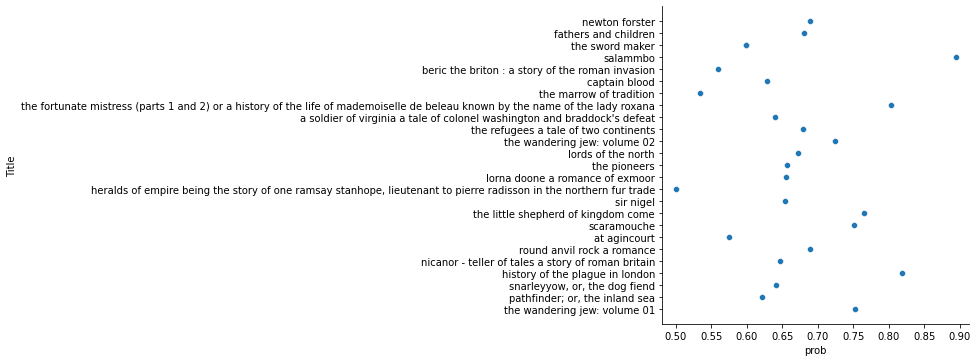

In [248]:
his = metapred.loc[metapred["Genre"] == "Historical"]
sns.relplot(data = his, x="prob", y="Title");

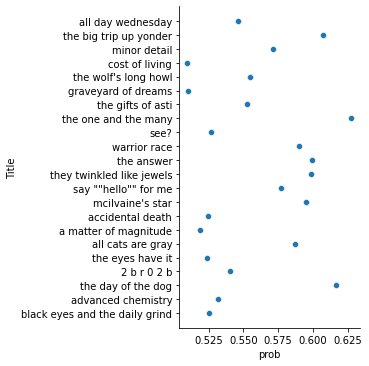

In [249]:
his = metapred.loc[metapred["Genre"] == "Sci-Fi"]
sns.relplot(data = his, x="prob", y="Title");

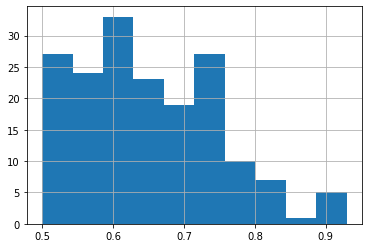

In [250]:
# A histogram of these probabilities
metapred['prob'].hist();

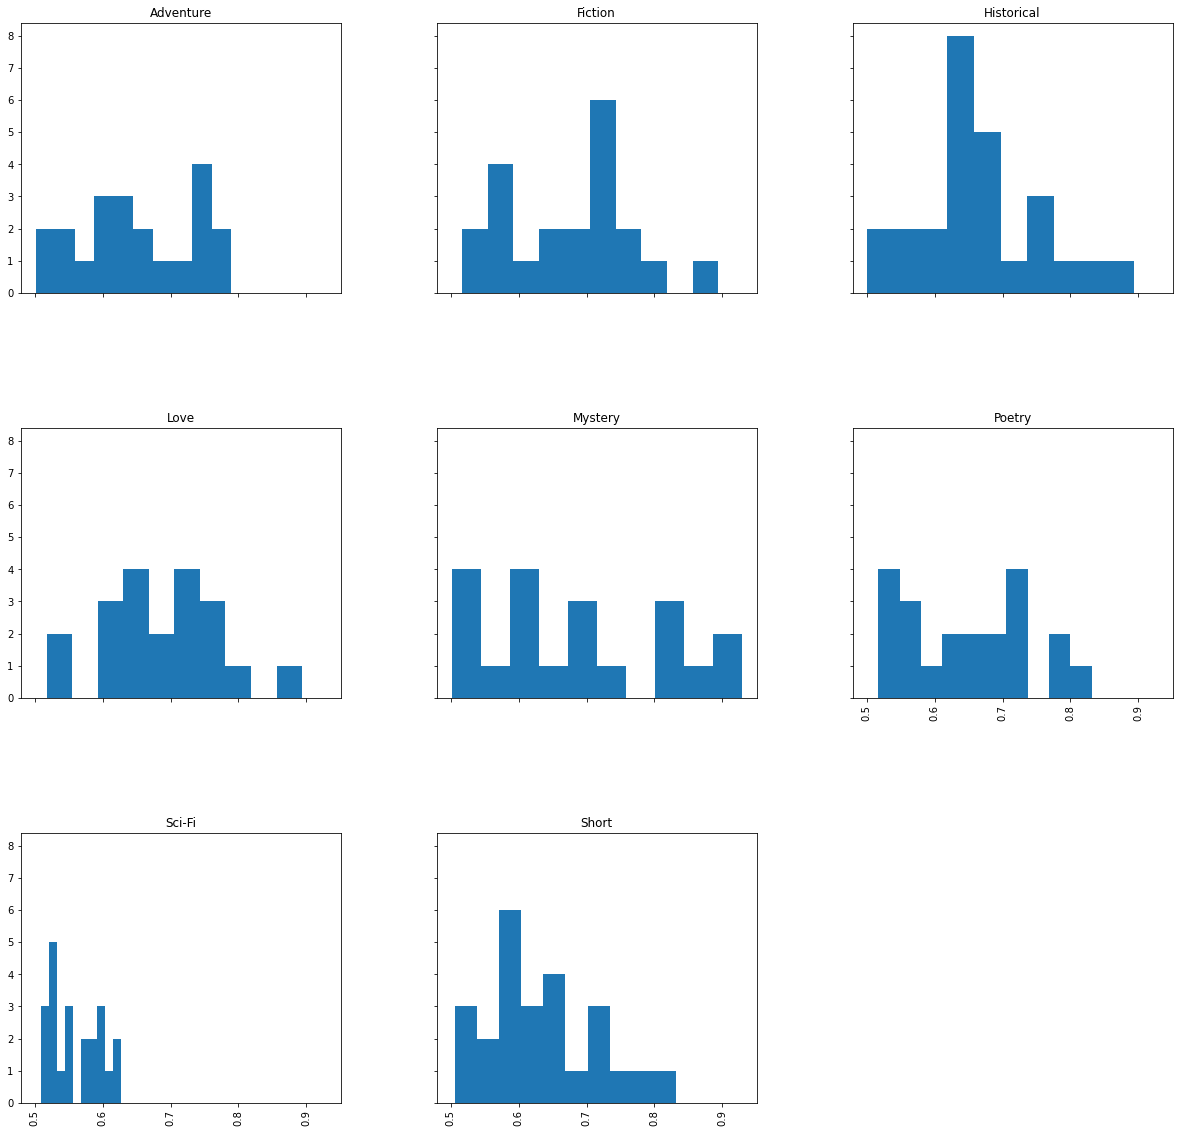

In [251]:
# Same thing, but with breakdown by Genre
metapred.hist(column='prob', by='Genre', figsize=(20, 20), sharex=True, sharey=True);

In [252]:
# Show probabilities of all labels for each novel (in case of 2 labels, this doesn't give extra information)
x = pandas.DataFrame(prob, index=newfiles, columns=clf.classes_)
x.loc[x.max(axis=1).sort_values().index, :]  # order from lowest to highest probability

,FAILURE,SUCCESS
18182.txt,0.4996,0.5004
12190.txt,0.4985,0.5015
3180.txt,0.4977,0.5023
23168.txt,0.5062,0.4938
29458.txt,0.4903,0.5097
...,...,...
14369.txt,0.8387,0.1613
1695.txt,0.1444,0.8556
1290.txt,0.1060,0.8940
2789.txt,0.8967,0.1033


Which words are most strongly associated with each label?
---------------------------------------------------------
For each label, the top 10 words most strongly linked to each label are shown.

The words are ordered by the weight of the model for each label combined with the average frequency of that word.

In [255]:
# Sort the weights of the classifier and take top items
n = 20
topfeatures = {}
avgfreq = numpy.squeeze(numpy.asarray(X.mean(axis=0)))
if len(clf.classes_) > 2:
    for n, target in enumerate(clf.classes_):
        top = numpy.argsort(clf.coef_[n] * avgfreq)[::-1][:n]
        topfeatures[target] = pandas.DataFrame({
                'word': [feature_names[m] for m in top],
                'score': (clf.coef_[n] * avgfreq)[top]},
                index=range(1, 11))
else:
    # in case of a binary classification, negative weights are for the first class,
    # positive weights for the second
    top = numpy.argsort(clf.coef_[0] * avgfreq)[:n]
    topfeatures[clf.classes_[0]] = pandas.DataFrame({
            'word': [feature_names[m] for m in top],
            'score': (clf.coef_[0] * avgfreq)[top]},
            index=range(1, n + 1))
    top = numpy.argsort(clf.coef_[0] * avgfreq)[::-1][:n]
    topfeatures[clf.classes_[1]] = pandas.DataFrame({
            'word': [feature_names[m] for m in top],
            'score': (clf.coef_[0] * avgfreq)[top]},
            index=range(1, n + 1))
    # the most "neutral" words are the words with a weight closest to zero;
    # i.e., these features provide almost no evidence whether one or the other label
    # is more likely.
    top = numpy.argsort(numpy.abs(clf.coef_[0]) * (1 - avgfreq))[:n]
    topfeatures['neutral'] = pandas.DataFrame({
            'word': [feature_names[m] for m in top],
            'weight': clf.coef_[0][top]},
            index=range(1, n + 1))  
pandas.concat(topfeatures, axis=1)

FAILURE             SUCCESS           neutral                   
   word        score   word      score   word           weight     
1         girl -0.0271        mr  0.0350      never had  2.4359e-06
2         miss -0.0179      thou  0.0220        how the -5.2547e-06
3    exclaimed -0.0130        de  0.0186        remarks  8.2004e-06
4     she said -0.0122       sir  0.0166        put her -3.2703e-05
5          tom -0.0119   she had  0.0159          crack -3.5018e-05
6         boys -0.0116        re  0.0150          ideal  3.5043e-05
7     the girl -0.0108      wind  0.0104  that it would  4.5372e-05
8           er -0.0098    letter  0.0092      not leave -5.5000e-05
9       doctor -0.0081       mrs  0.0084         set up  6.9378e-05
10     chapter -0.0079       sea  0.0080     it was his  7.2849e-05
11   the young -0.0076      thee  0.0076       far more -7.2921e-05
12      as she -0.0075  that she  0.0067        suppose -7.5321e-05
13        jack -0.0074    person  0.0066         in new  7.9550e-05
14       sweet -0.0072    window  0.0065         praise -9.7403e-05
15       frank -0.0060      lady  0.0058     to be seen  1.0096e-04
16       uncle -0.0060    madame  0.0057       would do -1.0454e-04
17    the boys -0.0050      mary  0.0056    the door of  1.0795e-04
18     laughed -0.0048     clock  0.0055       proposed -1.1019e-04
19      sister -0.0045      thus  0.0054        from it  1.1817e-04
20  the doctor -0.0044   towards  0.0054    attached to -1.2240e-04

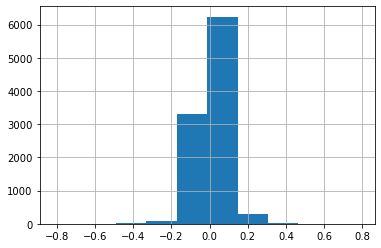

In [256]:
# Histogram of the distribution of weights
weights = pandas.Series(clf.coef_[0], index=feature_names)
weights.hist();

In [ ]:
genres = dict(zip(metadata.index, metadata['Genre']))
result = pandas.DataFrame([
            (authors[a].title(), titles[a].title(), genres[a], p, labels[a], b)
        for a, b, p in zip(newfiles, pred, prob.max(axis=1))],
        index=newfiles,
        columns=['Author', 'Title', 'Genre', 'prob', 'actual', 'predicted'])
result.sort_values(by='prob')